In [ ]:
# default_exp json_to_df

# Json to df

> This module turns raw json data into dataframes and adds responses, reaction times, and response forces.

In [ ]:
#hide
from nbdev.showdoc import *

ToDo:
- There are still some column names in here.
- Paths are appended with string append, should be os.path.join

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#export
from aat_analysis.utils import loadJson
from aat_analysis.constants import Constants as C
from aat_analysis.add_responses import add_responses
import json
import os
import pandas as pd
from pandas.api.types import is_numeric_dtype
import warnings
import numpy as np
from tqdm import tqdm
from operator import itemgetter
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [ ]:
#export
def get_sensor_data(data, key):
    if key in data:
        sensor_data = pd.Series(data[key])
        sensor_data.index = sensor_data.index.astype('int')
        sensor_data = sensor_data.sort_index()
        times = sensor_data.index.values
        sensor_data = sensor_data.values
    else:
        times, sensor_data = np.array([]),np.array([])
    return sensor_data, times

In [ ]:
#export
def addAATData(df, session, sessionName, task, inverted_stimulus_sets):
    for blockIndex, block in enumerate(session[task]['blocks'], 1):
        for trialIndex, trial in enumerate(block[1:], 1):
            if trial == None:
                continue
            # Note that extra practice trials get skipped
            if (sessionName,blockIndex,trialIndex) in df.index:
                # Setting trial variables
                row = (sessionName,blockIndex,trialIndex)
                df.at[row,C.CORRECT_RESPONSE_COLUMN] = trial['correctResponse'] # 1 = PUSH, 2 = PULL
                image_name = trial['imageName'].split('.')
                image_name = image_name[0] if isinstance(image_name, list) else np.nan
                df.at[row,C.STIMULUS_COLUMN] = image_name#trial['imageName'].split('.')#.apply(lambda x: x[0] if isinstance(x, list) else np.nan)
                df.at[row,C.DRAWN_AT_UNIX_COLUMN] = trial.get('drawnAtUnix', np.nan)
                df.at[row,C.DRAWN_AT_COLUMN] = trial.get('drawnAt', np.nan)
                df.at[row,C.STIMULUS_SET_COLUMN] = inverted_stimulus_sets.get(trial.get('imageName',None), np.nan)
                acc, times = get_sensor_data(trial, 'acceleration')
                df.at[row,C.TIME_COLUMN] = times
                df.at[row,C.ACCELERATION_COLUMN] = acc
                df.at[row,C.ACCELERATION_X_COLUMN] = get_sensor_data(trial, 'acceleration_x')[0]
                df.at[row,C.ACCELERATION_Y_COLUMN] = get_sensor_data(trial, 'acceleration_y')[0]
                gyro_x, gyro_times = get_sensor_data(trial, 'gyro_x')
                df.at[row,C.GYRO_TIME_COLUMN] = gyro_times
                df.at[row,C.GYRO_X_COLUMN] = gyro_x
                df.at[row,C.GYRO_Y_COLUMN] = get_sensor_data(trial, 'gyro_y')[0]
                df.at[row,C.GYRO_Z_COLUMN] = get_sensor_data(trial, 'gyro_z')[0]
    return df

In [ ]:
#export
def addSessionData(df, ppJson, sessionName, inverted_stimulus_sets):
    for task in sorted(ppJson[sessionName].keys()):
        if task == "AAT":
            df = addAATData(df, ppJson[sessionName], sessionName, task, inverted_stimulus_sets)
        elif task.startswith('PR'):
            for stimulus_name in ppJson[sessionName][task].keys():
                df.loc[df.stimulus==stimulus_name,task] = ppJson[sessionName][task][stimulus_name]['rating']
                #ratingDf.loc[stimulus_name,task] = ppJson[sessionName][task][stimulus_name]['rating']
        else:
            for question in ppJson[sessionName][task].keys():
                answer = ppJson[sessionName][task][question]['answer']
                if 'time' in ppJson[sessionName][task][question]:
                    time = ppJson[sessionName][task][question]['time']
                else:
                    time = None
                if is_numeric_dtype(df[question]):
                    answer = float(answer)
                df.loc[sessionName, question] = answer
                df.loc[sessionName, question + "_time"] = time
    return df

In [ ]:
#export
def makeParticipantTable(participantJson, df, inverted_stimulus_sets):
    '''This function creates dataframes for participants'''

    # Sometimes participantIds miss from the data
    participantKeys = { 'participantId':'participant',
                            'experiment':'experiment',
                            'device':'device',
                            'signed_up':'signed_up',
                            'sensor_type':'sensor_type',
                            'condition':'condition',
                            'saved_at':'saved_at',
                            'completion':'completion'}
    # Adding participant level data
    for jsonKey, tableColumn in participantKeys.items():
        if jsonKey in participantJson.keys():
            df[tableColumn] = participantJson[jsonKey]
    # Adding session level DataFrame
    keys = participantJson.keys()
    has_pr_list = []
    for key in participantJson.keys():
        if key not in participantKeys:
            has_pr = 0
            for task in sorted(participantJson[key].keys()):
                if task.startswith("PR"):
                    has_pr = 1
            has_pr_list.append([key,has_pr])

    has_pr_list = sorted(has_pr_list, key=itemgetter(1))
    keys = [item[0] for item in has_pr_list]
    

    for key in keys:#participantJson.keys():
        if key not in participantKeys:
            df = addSessionData(df, participantJson,key, inverted_stimulus_sets)
    df[C.CORRECT_RESPONSE_COLUMN].replace({1:'push',2:'pull'}, inplace=True)
    #ratingDf[C.PARTICIPANT_COLUMN] = participantJson['participantId']
    return df

In [ ]:
#export
def relabel_variables(data, tasks):
    labels = {}
    for task_item in tasks.items():
        task_name = task_item[0]
        task = task_item[1]
        task_type = task.get("type","")
        if task_type=="questionnaire":
            participant_questionnaire = task.get("level", "") == "participant"

            questions = task.get("questions",[])
            for index, question in enumerate(questions):
                if "id" not in question:
                    question["id"] = "%s_%02d"%(task_name,index+1)
                if (question.get("level","") == "participant") or participant_questionnaire:
                    if question['id'] in data:
                        data[question['id']] = data[question['id']].ffill().bfill() # Distributing participant variables

                if "label" in question:
                    #if "id" in question:
                    labels[question['id']] = question['label'] # Relabelling variables
                    #else:
                    #    labels["%s_%02d"%(task_name,index+1)]

    for item in labels.items():
        data[item[1]] = data[item[0]]
    return data

In [ ]:
#export
def json_to_df(input_dir,external_dir,interim_dir,condition_dict, limit= None, threshold = 1):
    stimulus_sets = loadJson(os.path.join(external_dir, "stimulus_sets.json"))
    tasks = loadJson(os.path.join(external_dir, "tasks.json"))
    inverted_stimulus_sets = dict( (v,k) for k in stimulus_sets for v in stimulus_sets[k] )
    errors = []
    for file in tqdm(list(os.scandir(input_dir))[:limit]):
        try:
            participant = file.name.split('.')[0]
            if file.name.endswith('.json'):
                participantJson = loadJson(file.path)
                if ('participantId' not in participantJson.keys()):
                    participantJson['participantId'] = participant
                if ('condition' in participantJson.keys()) & ('participantId' in participantJson.keys()):
                    conditionDf = condition_dict[participantJson['condition']]
                    conditionDf = conditionDf.copy(deep=True)
                    df = makeParticipantTable(participantJson, conditionDf, inverted_stimulus_sets)
                    df = df.reset_index().set_index(['participant','session','block','trial'])
                    df = add_responses(df, threshold = threshold)
                    #df = relabel_variables(df, tasks)
                    df.reset_index().to_pickle(os.path.join(interim_dir, "%s.pkl"%participant))
        except:
            errors.append(participant)
    if len(errors):
        print(errors)

In [ ]:
external_folder = "../data/external/"
interim_folder = "../data/interim/"
raw_data_folder = "../data/raw/"
processed_data_file = "../data/processed/data.csv"

In [ ]:
from aat_analysis.make_condition_templates import make_condition_templates

templates = make_condition_templates(external_folder)
# Preprocesses data for each participant and moves it to interim
json_to_df(raw_data_folder, external_folder, interim_folder, templates)

100%|█████████████████████████████████████████████| 3/3 [00:04<00:00,  1.64s/it]


In [ ]:
from aat_analysis.utils import merge_data
data = merge_data(interim_folder, drop=['interpolated','interpolated_gyro'])

<AxesSubplot:>

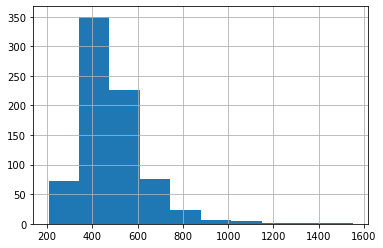

In [ ]:
data.rt.hist()

In [ ]:
data.rt.isna().mean()

0.019230769230769232